In [64]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as Keras
from keras.applications import ResNet50

from sklearn import metrics
from scipy.spatial import distance

import time

In [53]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
sys.path.append('/home/albert/github/tensorflow/')
import densenet
import triplet

### Mine Triplets

In [54]:
CAFFE_ROOT = '/home/albert/caffe/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [55]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

In [56]:
print train_files[0]

['/home/albert/caffe/data/market-1501/bounding_box_train/0575_c6s2_004068_01.jpg', 575]


In [57]:
print test_files[0]

['/home/albert/caffe/data/market-1501/bounding_box_test/0152_c2s1_024601_02.jpg', 152]


### Train Network

In [58]:
def normalize(im):
    return (im * 255.0 / im.max()).astype(np.uint8)

In [59]:
def extract_htmp(img_file, heatmap_file):
    color = misc.imread(img_file)
    gray = cv2.cvtColor(color,cv2.COLOR_BGR2GRAY)
    heatmap_img = misc.imread(heatmap_file)
    
    heatmaps = []
    htmp_height = heatmap_img.shape[0]
    # 57 heatmaps: 18 bodypaf_x[0] + paf_y[0] parts + bkgd + 2 x 19 PAFs
    htmp_width = int(heatmap_img.shape[1] / 57)
    
    for i in range(0, 57):
        htmp = np.array(heatmap_img[:, i * htmp_width : (i + 1) * htmp_width])
        htmp_resize = misc.imresize(htmp, float(gray.shape[0]) / htmp_height)
        htmp_resize = htmp_resize[:, 0:gray.shape[1]]
        heatmaps.append(htmp_resize)
        # plt.imshow(heatmaps[-1], cmap=plt.cm.gray)
        # plt.show()

    bdy_pt_htmps = heatmaps[0:18]
    bkgd = heatmaps[18]
    # Invert background heatmap (use white background instead of black background)
    # to produce heatmap with all body parts
    all_bdy_pts = [255] - bkgd
    return all_bdy_pts

In [60]:
# for f in train_img_dir:
#     if f[-4:] == '.jpg':
#         root = f[:f.index('.')]
#         img_path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/%s.jpg' % root
#         htmp_path = CAFFE_ROOT + 'data/market-1501/train_openpose/train_heatmaps/%s_heatmaps.png' % root
#         htmp = np.array([[3*[i/255.0] for i in row] for row in extract_htmp(img_path, htmp_path)])
#         misc.imsave(CAFFE_ROOT + 'data/market-1501/train_openpose/train_htmp_cropped/%s_htmp.png' % root, htmp)

In [61]:
# Number of identities
P_param = 18
# Number of images per identity
K_param = 4

In [62]:
def output_batch_generator(files_dict, labels, P=P_param, K=K_param):
    while True:
        batch = []
        idt_choice = np.random.choice(labels, P, replace=False)
        for p in range(len(idt_choice)):
            if K > len(files_dict[idt_choice[p]]):
                k_choice = np.random.choice(range(len(files_dict[idt_choice[p]])), K, replace=True)
            else:
                k_choice = np.random.choice(range(len(files_dict[idt_choice[p]])), K, replace=False)            
#             print k_choice, p
            for k in k_choice:
                img_path = files_dict[idt_choice[p]][k]
                img = misc.imread(img_path).astype(np.float64)
                root = img_path[len(img_path) - img_path[::-1].index('/'):-4:]
                htmp_path = CAFFE_ROOT + 'data/market-1501/train_openpose/train_htmp_cropped/%s_htmp.png' % root
                htmp = misc.imread(htmp_path)
                htmp = htmp / float(htmp.max())
                batch.append((img*htmp).astype(np.uint8).tolist())
        output = np.array(batch, dtype=np.uint8)
        yield(output, np.zeros((P*K, 128)))

0.709117174149


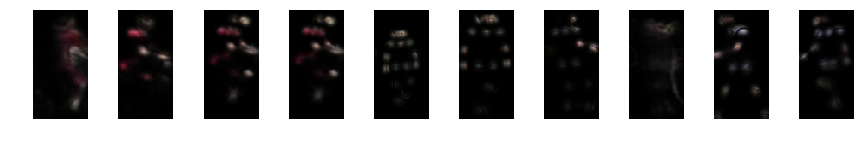

In [65]:
start = time.time()
train_batch = output_batch_generator(train_dict, train_labels).next()
print time.time() - start
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_batch[0][i])
    plt.axis('off')
plt.show()

In [12]:
def log1p(x):
    return Keras.log(1 + Keras.exp(x))

In [13]:
def dist(x1, x2):
    return Keras.sum(Keras.abs(x1 - x2), axis=1)

In [14]:
def triplet_loss(y_true, y_pred, margin=0.5, P=P_param, K=K_param, output_dim = 128):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))

    loss = tf.Variable(1, dtype=tf.float32)

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                      embeddings[(i + 1)*K:]], 0)))
            loss += margin + hard_pos - hard_neg
    return loss

In [15]:
def evaluate_rank(net, rank, all_embeddings, all_identities, files_arr, test_iter=1000, shape=(128,64)):
    correct = 0
    f_choice = np.random.choice(range(len(files_arr)), np.minimum(test_iter, len(files_arr)), replace=False)
    for f in f_choice:
        query_img = misc.imread(files_arr[f][0])
        query_embedding = net.predict(query_img.reshape(1, shape[0], shape[1], 3))
        distance_vectors = np.squeeze(np.abs(all_embeddings - query_embedding))
        distance = np.sum(distance_vectors, axis=1)
        top_inds = distance.argsort()[:rank+1]
        output_classes = np.array(all_identities)[top_inds].astype(np.uint16)
        
        i = 0
        for c in output_classes:
            if c == int(files_arr[f][1]):
                i += 1
        if i > 1:
            correct += 1
    return float(correct)/test_iter

In [16]:
def pos_pair_generator(files_dict):
    while True:
        idt = np.random.choice(files_dict.keys(), 1, replace=False)[0]
        sample_choice = np.random.choice(range(len(files_dict[idt])), np.minimum(2, len(files_dict[idt])), replace=False)
        pair = [misc.imread(files_dict[idt][p]).tolist() for p in sample_choice]
        yield(np.array(pair).astype(np.uint8))

In [17]:
def neg_pair_generator(files_dict):
    while True:
        idt_choice = np.random.choice(files_dict.keys(), 2, replace=False)
        pair = []
        for idt in idt_choice:
            sample = np.random.choice(range(len(files_dict[idt])), 1, replace=False)[0]
            pair.append(misc.imread(files_dict[idt][sample]).tolist())
        yield(np.array(pair).astype(np.uint8))

In [18]:
def l2(x1, x2):
    l2 = np.sqrt(np.sum(np.power(x1 - x2, 2)))
    return l2

In [19]:
def evaluate_dist(model, generator, n_pairs=1000):
    distances = []
    for t in range(n_pairs):
        pair = generator.next()   
        predict = [model.predict(pair[i].reshape(1,128,64,3)) for i in range(2)]
        dist = distance.cosine(predict[0], predict[1])
        distances.append(dist)
    return distances

According to the triplet loss paper, use an adaptive learning rate decay that is constant at first, then decays exponentially.

In [21]:
# https://medium.com/towards-data-science/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
def step_decay(epoch):
    initial_lr = 0.0003
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lr * np.power(drop,  
           np.floor((1+epoch)/epochs_drop))
    return lrate

def step_decay_cont(epoch, init_epoch, init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    lrate = init_lr * np.power(drop,  
           np.floor((1 + epoch + init_epoch)/epochs_drop))
    return lrate

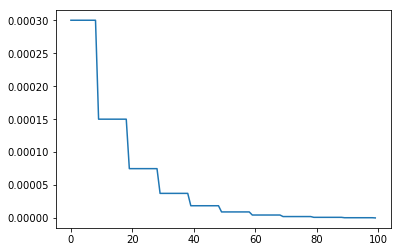

In [22]:
lr = []
for i in range(100):
    lr.append(step_decay(i))
plt.plot(np.arange(100), lr)

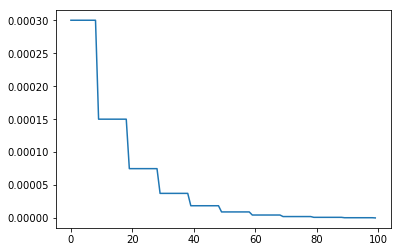

In [23]:
lr = []
for i in range(4):
    for j in range(25):
        lr.append(step_decay_cont(j, 25*i, 0.0003))
plt.plot(np.arange(100), lr)

In [24]:
def get_score(model, files_dict, files_arr, file_root, score, iterations):
    all_embeddings = []
    all_identities = []
    for idt in files_dict.keys():
        for f in files_dict[idt]:
            img = misc.imread(f)
            predict = model.predict(img.reshape(1, 128, 64, 3))
            all_embeddings.append(predict)
            all_identities.append(idt)

    for rank in [1,5,20]:
        rank_arr = []
        for x in range(3):
            rank_score = evaluate_rank(trinet, rank, all_embeddings, 
                                       all_identities, files_arr, test_iter=1000)
            rank_arr.append(rank_score)
        score['rank%d' % rank][iterations] = rank_arr
    
    pos_generator = pos_pair_generator(files_dict)
    neg_generator = neg_pair_generator(files_dict)
    
    pos_distance = evaluate_dist(model, pos_generator)
    score['pos_distance'][iterations] = pos_distance
    
    neg_distance = evaluate_dist(model, neg_generator)
    score['neg_distance'][iterations] = neg_distance
    
    score['precision'][iterations] = []
    score['recall'][iterations] = []
    score['matt_coef'][iterations] = []
    
    for thresh in np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:]:
        true = np.ones(len(pos_distance)).tolist() + np.zeros(len(neg_distance)).tolist()
        pred_pos = [int(d < thresh) for d in pos_distance]
        pred_neg = [int(d < thresh) for d in neg_distance]
        pred = pred_pos + pred_neg

        score['precision'][iterations].append(metrics.precision_score(true, pred))
        score['recall'][iterations].append(metrics.recall_score(true, pred))
        score['matt_coef'][iterations].append(metrics.matthews_corrcoef(true, pred))
    
    score['loss'] += history.history['loss']
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    score['file_name'][iterations] = file_name
    
    return score

Replace top layer of DenseNet with a FC layer (1024) with batch normalization and ReLU and a FC layer (128). Train with all layers as learnable for 50 epochs with learning rate decay 1e-6.

In [25]:
# with tf.device('/cpu:0'):
# https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
i = 0
image_dim = (224, 224, 3)
base_model = densenet.DenseNetImageNet121(input_shape=(128,64,3))

base_model.outputs = [base_model.layers[-2].output]
base_model.layers[-1].outbound_nodes = []

# https://datascience.stackexchange.com/questions/21610/prepending-input-layer-to-pre-trained-model
x = base_model.outputs[0] # (new_input)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128)(x)

trinet = Model(inputs=base_model.input, outputs=predictions)
trinet.compile(loss=triplet_loss, optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

for layer in trinet.layers:
    layer.trainable = True

Weights for the model were loaded successfully


In [26]:
trinet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 64, 3)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 32, 64)    9408        input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 64, 32, 64)    256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 64, 32, 64)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [27]:
train_score = {
    'rank1' : {},
    'rank5' : {},
    'rank20' : {},
    'pos_distance' : {},
    'neg_distance' : {},
    'precision' : {},
    'recall' : {},
    'matt_coef' : {},
    'loss' : [],
    'file_name' : {}
}

test_score = {
    'rank1' : {},
    'rank5' : {},
    'rank20' : {},
    'pos_distance' : {},
    'neg_distance' : {},
    'precision' : {},
    'recall' : {},
    'matt_coef' : {},
    'loss' : [],
    'file_name' : {}
}

Epoch 1/10
100/100 [==============================] - 68s - loss: 1458.5838    
Epoch 2/10
100/100 [==============================] - 63s - loss: 878.0099    
Epoch 3/10
100/100 [==============================] - 64s - loss: 439.6227    
Epoch 4/10
100/100 [==============================] - 64s - loss: -37.5584    
Epoch 5/10
100/100 [==============================] - 64s - loss: -347.1551    
Epoch 6/10
100/100 [==============================] - 64s - loss: -1281.6523    
Epoch 7/10
100/100 [==============================] - 63s - loss: -1736.4606    
Epoch 8/10
100/100 [==============================] - 63s - loss: -2945.6705    
Epoch 9/10
100/100 [==============================] - 63s - loss: -4251.6454    
Epoch 10/10
100/100 [==============================] - 64s - loss: -7295.5064    


/home/albert/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/albert/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


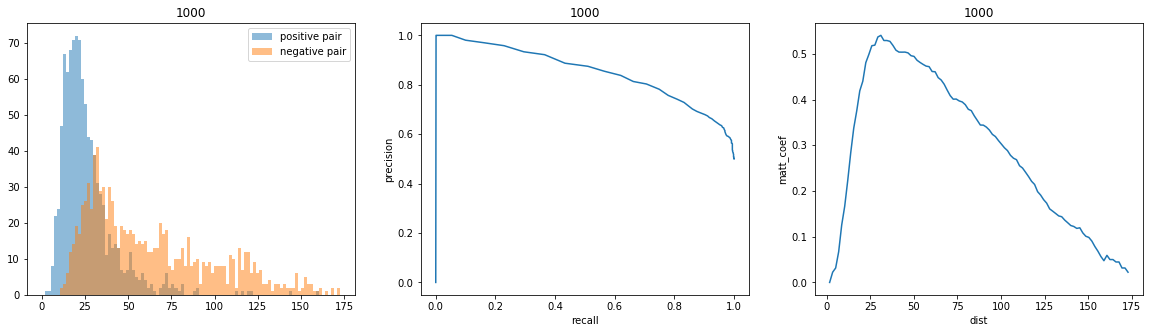

rank1 [0.403, 0.38, 0.408]
rank5 [0.618, 0.645, 0.635]
rank20 [0.799, 0.78, 0.785]


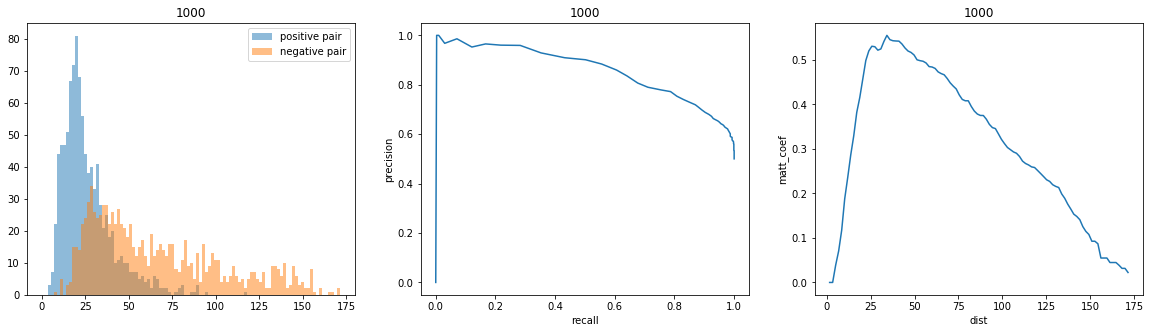

rank1 [0.343, 0.344, 0.375]
rank5 [0.624, 0.597, 0.599]
rank20 [0.762, 0.77, 0.781]
Epoch 1/10
100/100 [==============================] - 64s - loss: -10586.8054    
Epoch 2/10
100/100 [==============================] - 63s - loss: -13885.9015    
Epoch 3/10
100/100 [==============================] - 62s - loss: -17497.7937    
Epoch 4/10
100/100 [==============================] - 62s - loss: -19295.5759    
Epoch 5/10
100/100 [==============================] - 61s - loss: -26735.1562    
Epoch 6/10
100/100 [==============================] - 64s - loss: -32730.2146    
Epoch 7/10
100/100 [==============================] - 63s - loss: -39173.7376    
Epoch 8/10
100/100 [==============================] - 62s - loss: -44710.0610    
Epoch 9/10
100/100 [==============================] - 63s - loss: -47402.2255    
Epoch 10/10
100/100 [==============================] - 63s - loss: -61085.7425    


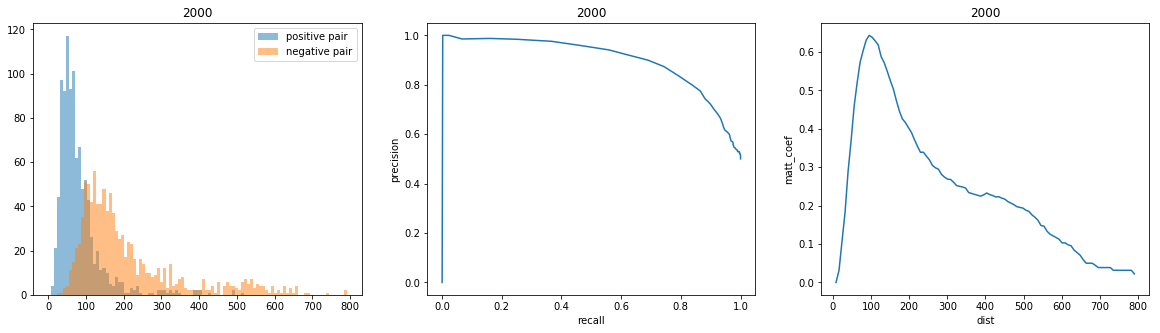

rank1 [0.399, 0.408, 0.436]
rank5 [0.664, 0.669, 0.674]
rank20 [0.81, 0.808, 0.836]


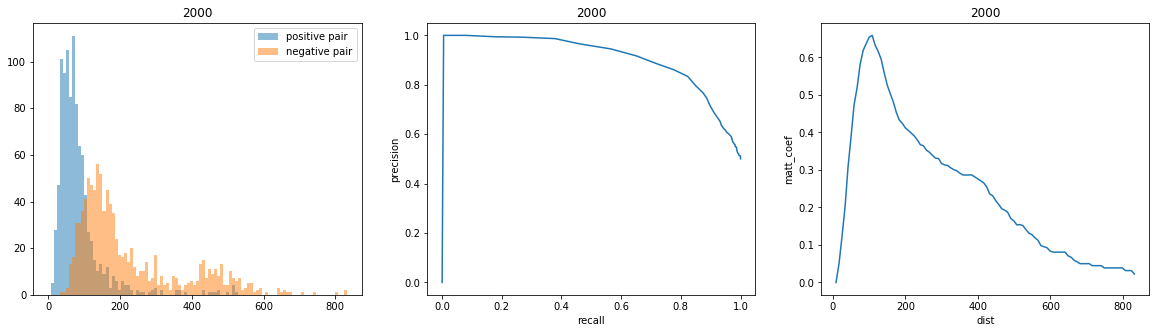

rank1 [0.351, 0.336, 0.347]
rank5 [0.618, 0.623, 0.62]
rank20 [0.793, 0.807, 0.815]
Epoch 1/10
100/100 [==============================] - 64s - loss: -70271.9720    
Epoch 2/10
100/100 [==============================] - 62s - loss: -75770.9024    
Epoch 3/10
100/100 [==============================] - 64s - loss: -87681.8367    
Epoch 4/10
100/100 [==============================] - 62s - loss: -95688.0051    
Epoch 5/10
100/100 [==============================] - 63s - loss: -97015.6855    
Epoch 6/10
100/100 [==============================] - 62s - loss: -106869.8322    
Epoch 7/10
100/100 [==============================] - 62s - loss: -121572.5993    
Epoch 8/10
100/100 [==============================] - 63s - loss: -120963.4228    
Epoch 9/10
100/100 [==============================] - 63s - loss: -125789.3547    
Epoch 10/10
100/100 [==============================] - 62s - loss: -136354.3635    


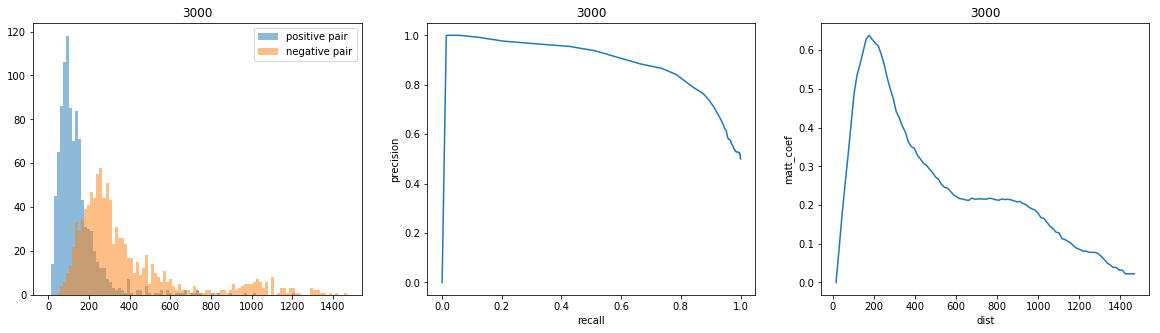

rank1 [0.349, 0.334, 0.322]
rank5 [0.606, 0.594, 0.617]
rank20 [0.812, 0.804, 0.813]


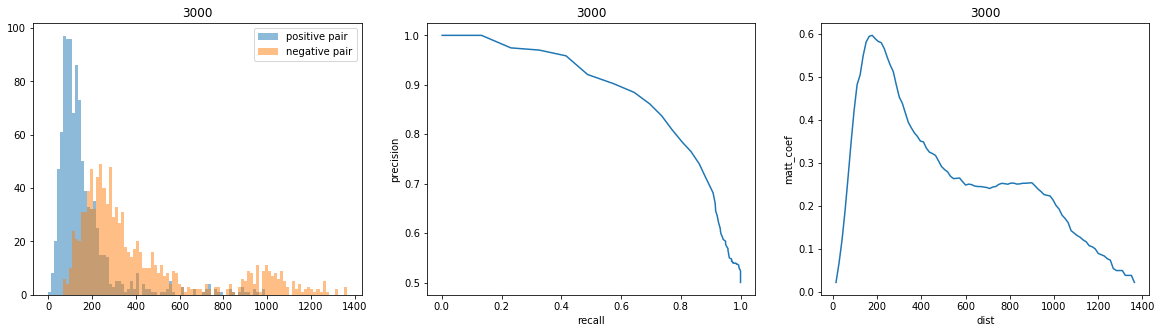

rank1 [0.315, 0.289, 0.291]
rank5 [0.556, 0.535, 0.528]
rank20 [0.742, 0.752, 0.766]
Epoch 1/10
100/100 [==============================] - 63s - loss: -146828.2887    
Epoch 2/10
100/100 [==============================] - 61s - loss: -152375.7559    
Epoch 3/10
100/100 [==============================] - 65s - loss: -162055.0854    
Epoch 4/10
100/100 [==============================] - 61s - loss: -163170.3918    
Epoch 5/10
100/100 [==============================] - 63s - loss: -167120.5671    
Epoch 6/10
100/100 [==============================] - 64s - loss: -176102.0834    
Epoch 7/10
100/100 [==============================] - 62s - loss: -180995.0203    
Epoch 8/10
100/100 [==============================] - 62s - loss: -189517.4734    
Epoch 9/10
100/100 [==============================] - 63s - loss: -195652.3981    
Epoch 10/10
100/100 [==============================] - 63s - loss: -200042.2111    


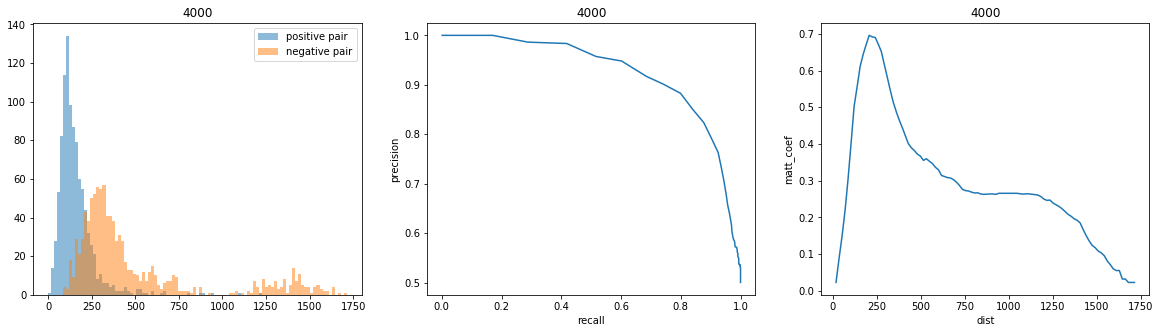

rank1 [0.333, 0.35, 0.323]
rank5 [0.606, 0.62, 0.603]
rank20 [0.821, 0.826, 0.81]


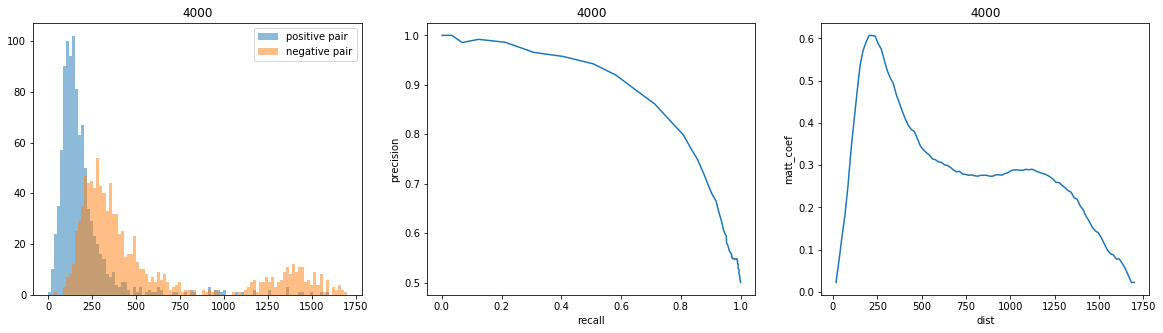

rank1 [0.257, 0.287, 0.293]
rank5 [0.573, 0.533, 0.556]
rank20 [0.756, 0.767, 0.761]
Epoch 1/10
100/100 [==============================] - 62s - loss: -206814.3394    
Epoch 2/10
100/100 [==============================] - 62s - loss: -212192.4040    
Epoch 3/10
100/100 [==============================] - 62s - loss: -210293.1505    
Epoch 4/10
100/100 [==============================] - 63s - loss: -209448.6323    
Epoch 5/10
100/100 [==============================] - 63s - loss: -213597.8822    
Epoch 6/10
100/100 [==============================] - 62s - loss: -228549.2922    
Epoch 7/10
100/100 [==============================] - 62s - loss: -220833.6769    
Epoch 8/10
100/100 [==============================] - 62s - loss: -221207.3062    
Epoch 9/10
100/100 [==============================] - 62s - loss: -228836.0714    
Epoch 10/10
100/100 [==============================] - 62s - loss: -236510.3209    


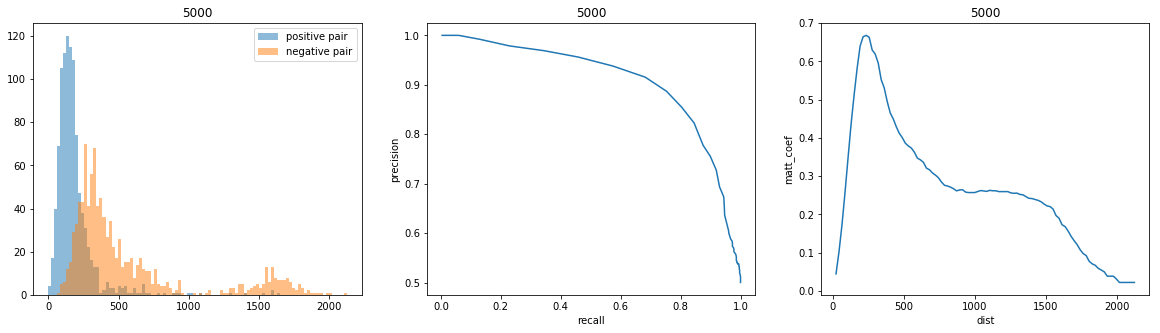

rank1 [0.312, 0.321, 0.323]
rank5 [0.591, 0.612, 0.585]
rank20 [0.795, 0.784, 0.812]


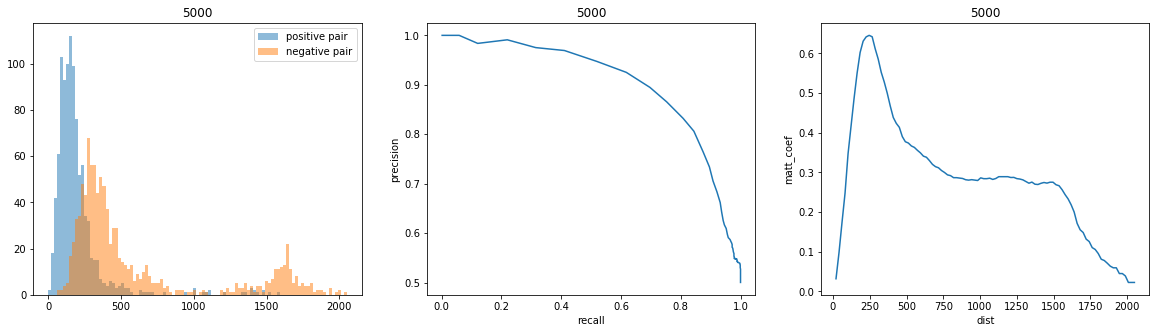

rank1 [0.239, 0.274, 0.253]
rank5 [0.54, 0.541, 0.523]
rank20 [0.756, 0.741, 0.731]
Epoch 1/10
100/100 [==============================] - 64s - loss: -239034.1903    
Epoch 2/10
100/100 [==============================] - 62s - loss: -230695.4148    
Epoch 3/10
100/100 [==============================] - 61s - loss: -243546.3861    
Epoch 4/10
100/100 [==============================] - 62s - loss: -238015.5398    
Epoch 5/10
100/100 [==============================] - 62s - loss: -242579.2173    
Epoch 6/10
100/100 [==============================] - 62s - loss: -245347.5428    
Epoch 7/10
100/100 [==============================] - 63s - loss: -248833.5167    
Epoch 8/10
100/100 [==============================] - 62s - loss: -247718.4361    
Epoch 9/10
100/100 [==============================] - 62s - loss: -248595.4955    
Epoch 10/10
100/100 [==============================] - 63s - loss: -251845.6727    


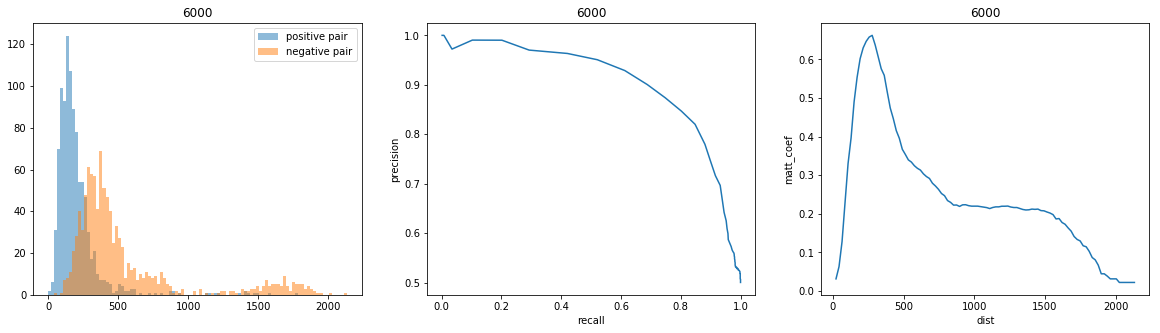

rank1 [0.33, 0.336, 0.336]
rank5 [0.599, 0.587, 0.592]
rank20 [0.79, 0.789, 0.785]


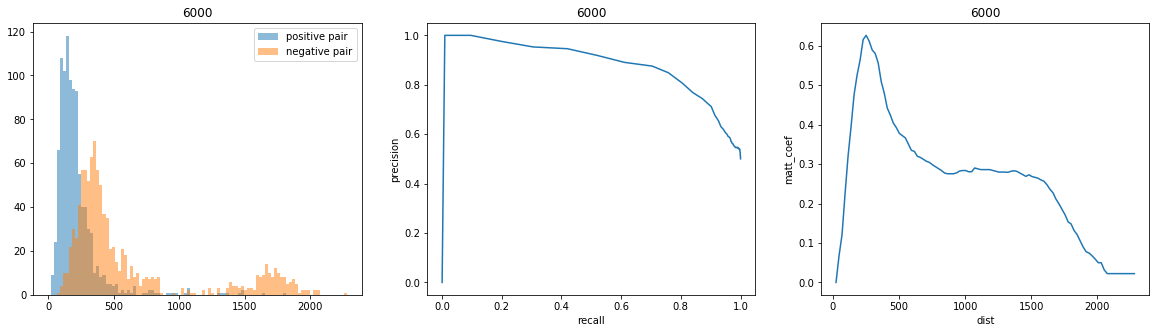

rank1 [0.259, 0.268, 0.269]
rank5 [0.523, 0.526, 0.5]
rank20 [0.761, 0.737, 0.743]
Epoch 1/10
100/100 [==============================] - 65s - loss: -250566.3756    
Epoch 2/10
100/100 [==============================] - 61s - loss: -249506.4141    
Epoch 3/10
100/100 [==============================] - 63s - loss: -258799.7069    
Epoch 4/10
100/100 [==============================] - 62s - loss: -243031.7841    
Epoch 5/10
100/100 [==============================] - 62s - loss: -258285.4166    
Epoch 6/10
100/100 [==============================] - 62s - loss: -252225.0211    
Epoch 7/10
100/100 [==============================] - 62s - loss: -253248.0500    
Epoch 8/10
100/100 [==============================] - 62s - loss: -262964.8438    
Epoch 9/10
100/100 [==============================] - 62s - loss: -258632.3756    
Epoch 10/10
100/100 [==============================] - 62s - loss: -263007.5516    


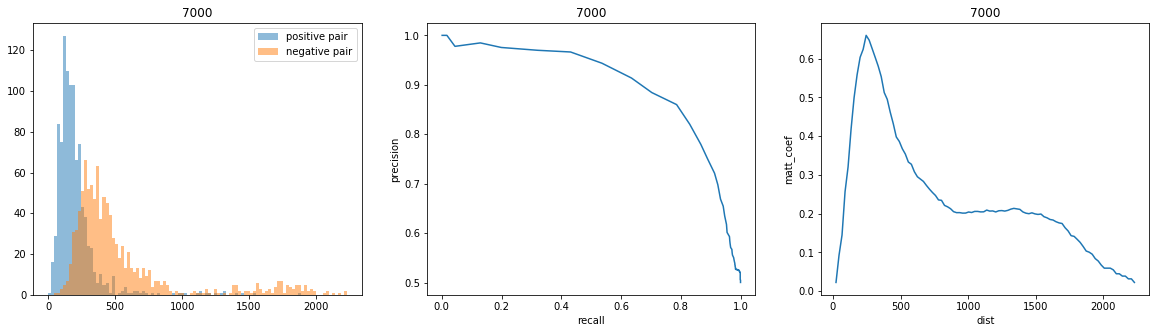

rank1 [0.32, 0.315, 0.306]
rank5 [0.595, 0.592, 0.615]
rank20 [0.797, 0.791, 0.771]


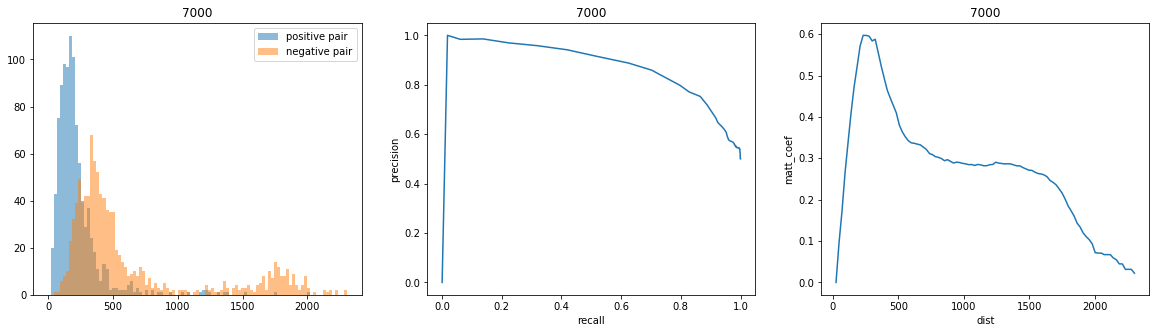

rank1 [0.229, 0.261, 0.235]
rank5 [0.504, 0.518, 0.512]
rank20 [0.742, 0.737, 0.741]
Epoch 1/10
100/100 [==============================] - 64s - loss: -260215.5308    
Epoch 2/10
100/100 [==============================] - 62s - loss: -253353.4543    
Epoch 3/10
100/100 [==============================] - 62s - loss: -263298.1466    
Epoch 4/10
100/100 [==============================] - 62s - loss: -264428.3373    
Epoch 5/10
100/100 [==============================] - 63s - loss: -267696.2259    
Epoch 6/10
100/100 [==============================] - 62s - loss: -259761.3581    
Epoch 7/10
100/100 [==============================] - 63s - loss: -272473.4634    
Epoch 8/10
100/100 [==============================] - 63s - loss: -261027.1225    
Epoch 9/10
100/100 [==============================] - 62s - loss: -264026.1677    
Epoch 10/10
100/100 [==============================] - 62s - loss: -268008.2195    


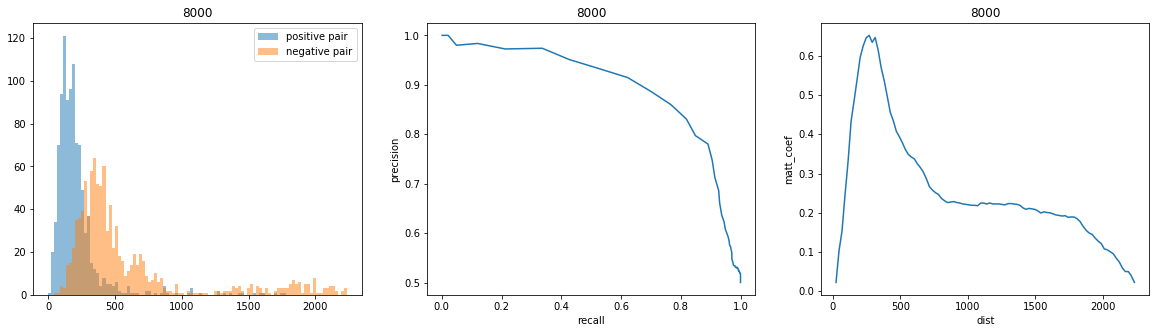

rank1 [0.31, 0.317, 0.324]
rank5 [0.6, 0.579, 0.586]
rank20 [0.786, 0.792, 0.777]


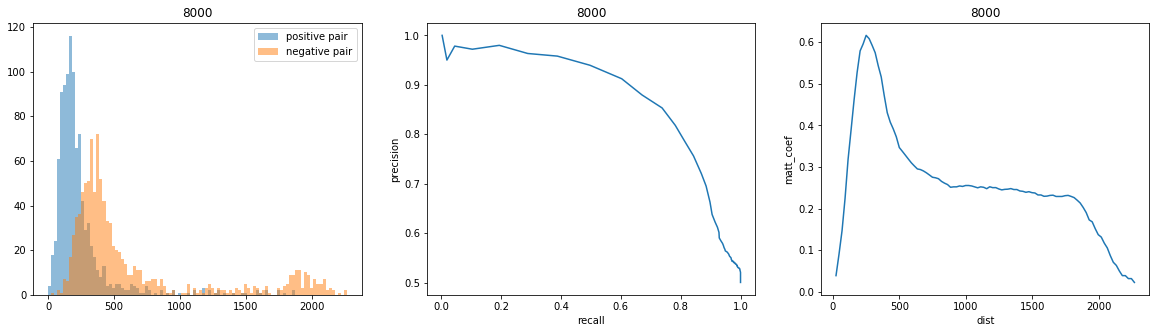

rank1 [0.249, 0.278, 0.255]
rank5 [0.534, 0.524, 0.498]
rank20 [0.745, 0.733, 0.739]
Epoch 1/10
100/100 [==============================] - 63s - loss: -265036.5614    
Epoch 2/10
100/100 [==============================] - 62s - loss: -264470.4002    
Epoch 3/10
100/100 [==============================] - 63s - loss: -266571.9164    
Epoch 4/10
100/100 [==============================] - 62s - loss: -261995.6852    
Epoch 5/10
100/100 [==============================] - 62s - loss: -264056.5613    
Epoch 6/10
100/100 [==============================] - 62s - loss: -264599.6112    
Epoch 7/10
100/100 [==============================] - 63s - loss: -261713.4180    
Epoch 8/10
100/100 [==============================] - 62s - loss: -257269.8419    
Epoch 9/10
100/100 [==============================] - 62s - loss: -267710.0637    
Epoch 10/10
100/100 [==============================] - 62s - loss: -275519.1272    


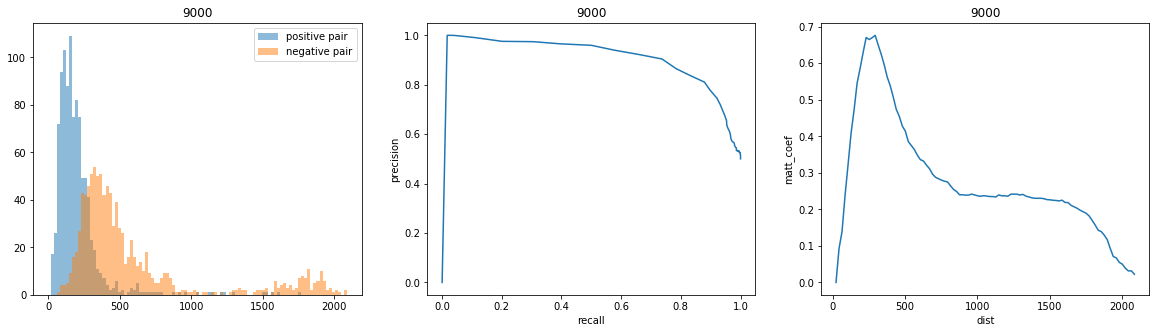

rank1 [0.311, 0.314, 0.33]
rank5 [0.64, 0.578, 0.583]
rank20 [0.782, 0.785, 0.801]


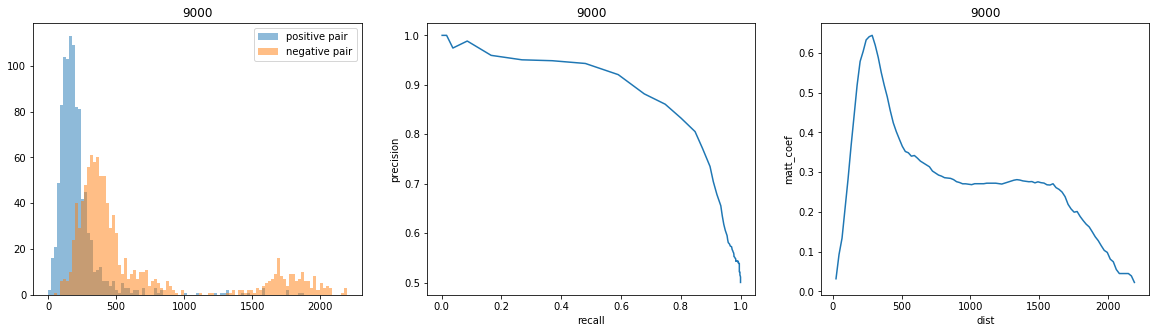

rank1 [0.254, 0.251, 0.264]
rank5 [0.488, 0.521, 0.514]
rank20 [0.736, 0.753, 0.745]
Epoch 1/10
100/100 [==============================] - 63s - loss: -265748.8384    
Epoch 2/10
100/100 [==============================] - 63s - loss: -266742.0973    
Epoch 3/10
100/100 [==============================] - 63s - loss: -266460.5840    
Epoch 4/10
100/100 [==============================] - 63s - loss: -270869.3798    
Epoch 5/10
100/100 [==============================] - 62s - loss: -265744.2798    
Epoch 6/10
100/100 [==============================] - 62s - loss: -260736.9145    
Epoch 7/10
100/100 [==============================] - 62s - loss: -265294.8216    
Epoch 8/10
100/100 [==============================] - 62s - loss: -266220.6478    
Epoch 9/10
100/100 [==============================] - 62s - loss: -268413.6291    
Epoch 10/10
100/100 [==============================] - 62s - loss: -264681.7628    


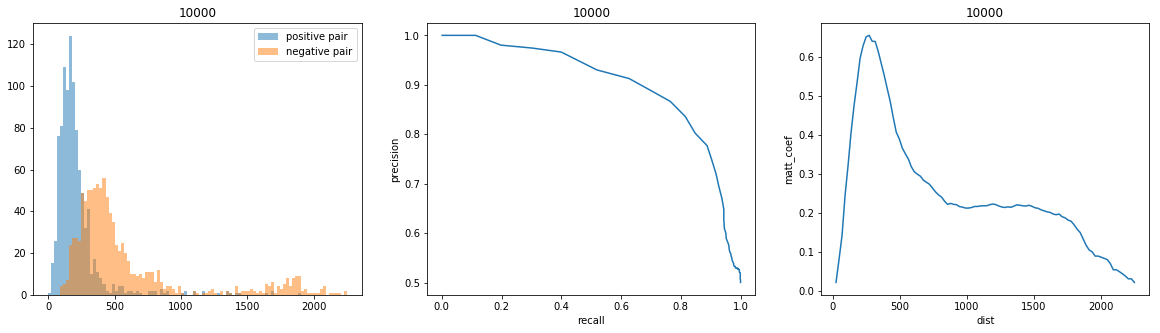

rank1 [0.298, 0.321, 0.313]
rank5 [0.595, 0.592, 0.601]
rank20 [0.779, 0.786, 0.794]


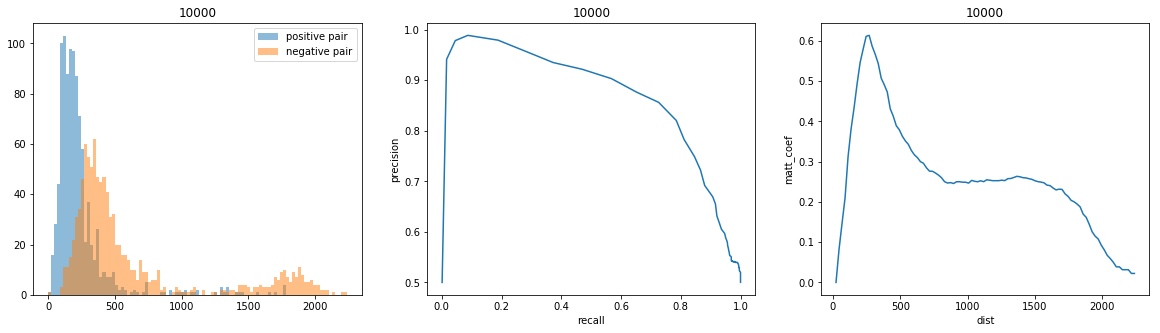

rank1 [0.285, 0.273, 0.25]
rank5 [0.53, 0.554, 0.545]
rank20 [0.739, 0.736, 0.749]


In [28]:
epochs = 10
steps_per_epoch = 100

file_root = 'densenet_triplet_htmp_2'

history = History()

for era in range(1,11):
    iterations = era * steps_per_epoch * epochs
    
    def step_decay_cont(epoch, init_epoch=epochs*(era - 1), init_lr=0.0003):
        drop = 0.5
        epochs_drop = 10.0
        lrate = init_lr * np.power(drop,  
               np.floor((1 + epoch + init_epoch)/epochs_drop))
        return lrate
    
    lrate = LearningRateScheduler(step_decay_cont)
    
    trinet.fit_generator(output_batch_generator(train_dict, train_labels), 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=epochs,
                        callbacks=[lrate, history])

    file_name = file_root + '_' + str(iterations) + '.h5'
    trinet.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))

    train_score = get_score(trinet, train_dict, train_files, file_root, train_score, iterations)
    test_score = get_score(trinet, test_dict, test_files, file_root, test_score, iterations)

    for score in [train_score, test_score]:
        plt.figure(figsize=(20,5))
        plt.subplot(1,3,1)
        pos_distance = score['pos_distance'][iterations]
        neg_distance = score['neg_distance'][iterations]
        bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
        plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
        plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
        plt.legend(loc='upper right')
        plt.title(str(iterations))

        plt.subplot(1,3,2)
        plt.plot(score['recall'][iterations], score['precision'][iterations])
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.title(str(iterations))

        plt.subplot(1,3,3)
        plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
                 score['matt_coef'][iterations])
        plt.xlabel('dist')
        plt.ylabel('matt_coef')
        plt.title(str(iterations))
        plt.show()

        print 'rank1', score['rank1'][iterations]
        print 'rank5', score['rank5'][iterations]
        print 'rank20', score['rank20'][iterations]

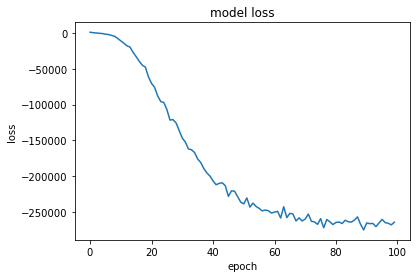

In [29]:
# summarize history for loss
plt.plot(score['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [30]:
train_rank1_avg = []
train_rank5_avg = []
train_rank20_avg = []
test_rank1_avg = []
test_rank5_avg = []
test_rank20_avg = []

for iterations in train_score['rank5'].keys():
    train_rank1_avg.append(np.average(np.array(train_score['rank1'][iterations])))
    train_rank5_avg.append(np.average(np.array(train_score['rank5'][iterations])))
    train_rank20_avg.append(np.average(np.array(train_score['rank20'][iterations])))
    test_rank1_avg.append(np.average(np.array(test_score['rank1'][iterations])))
    test_rank5_avg.append(np.average(np.array(test_score['rank5'][iterations])))
    test_rank20_avg.append(np.average(np.array(test_score['rank20'][iterations])))

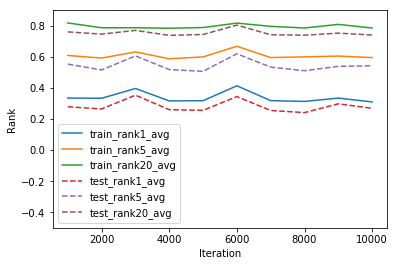

In [39]:
plt.plot(np.arange(1000,iterations+1000,1000), train_rank1_avg, label='train_rank1_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank5_avg, label='train_rank5_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank20_avg, label='train_rank20_avg')

plt.plot(np.arange(1000,iterations+1000,1000), test_rank1_avg, label='test_rank1_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank5_avg, label='test_rank5_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank20_avg, label='test_rank20_avg', linestyle='--')
plt.legend(loc='lower left')
plt.xlabel('Iteration')
plt.ylabel('Rank')
plt.ylim(-0.5,0.9)
plt.show()

In [37]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)